In [ ]:
import numpy as np
from datetime import datetime
import os
import src.Normal_model as Normal_model
from tqdm import tqdm
import src.utils as utils
import matplotlib.pyplot as plt
import torch
np.random.seed(80805)
x_train, y_train, _, x_val, y_val, y_val_idx = utils.load_data('./data/MNIST_1000')
print(x_train.shape)
print(x_val.shape)
#print(x_train.dtype)

repeat = 1

x_train = np.tile(x_train.reshape(len(x_train), -1), repeat)
x_val = np.tile(x_val.reshape(len(x_val), -1), repeat)

########################################################################3
N_epoch = 100
input_size = i_s = 40
hidden_size = h_s = 64
output_size = o_s = 196 * repeat
N_spins = input_size + hidden_size + output_size




normal_model = Normal_model.Normal_model(input_size, hidden_size, output_size, lr = 1/128)
###########################################################################

time_string = datetime.now().isoformat(timespec='minutes')
folder_name = f'./results/GradientDescent_rev_{time_string}_MNIST_1000'
os.system(f'mkdir {folder_name}')
os.system(f'mkdir {folder_name}/weights')
os.system(f'touch {folder_name}/train_log.txt')
utils.save_obj(f'{folder_name}/normal_model.pkl', normal_model) # pickle cannot save openjij schedule object

# ep_model.create_schedule()
# with open(f'{folder_name}/train_log.txt', 'a') as f:
#     f.write(f'beta={ep_model.beta}\tlr=1/{1/ep_model.lr}\tbatch_size = {ep_model.max_process}\tnum_walk = 2**({np.log2(ep_model.N_neal_temps)} + {np.log2(ep_model.N_neal_steps)})\trev_neal_temp = {ep_model.rev_neal_start_temp:.1f}\n')

train_batch_idx = utils.batch_idx(N=len(x_train), batch_size=4)
val_batch_idx = utils.batch_idx(N=len(x_val), batch_size=4)


best_reconstruction_loss = 1
reconstruction_loss_history = []
for epoch in range(N_epoch):
    N_train_correct = N_val_correct = 0
    reconstruction_loss = 0
    for s, e in tqdm(train_batch_idx, desc=f'epoch {epoch}'): #start and end index of minibatch
        _, rec_loss = normal_model.train(torch.tensor(y_train[s:e]).float(), torch.tensor(x_train[s:e]).float())
        #print(loss)
        #N_train_correct += (pred == ep_model.label_to_num(y_train[s:e])).sum()
        reconstruction_loss += rec_loss
    train_acc = N_train_correct / len(x_train)
    reconstruction_loss /= len(x_train)
    # for s, e in val_batch_idx:
    #     pred = normal_model.forward(torch.tensor(x_val[s:e]).float())
    #     #print((pred>0)*2-1)
    #     tmp = normal_model.label_to_num(np.array( (pred>0)*2-1))
    #     N_val_correct += (y_val_idx[s:e] == normal_model.label_to_num(np.array( (pred>0)*2-1) )).sum()
    #     print('////////////////')
    #     print(y_val_idx[s:e])
    #     print(tmp)
    #val_acc = N_val_correct / len(x_val)
    reconstruction_loss_history.append([reconstruction_loss])

    print(f'\treconstruction_loss: {reconstruction_loss*100}%')

    #acc_history.append([train_acc, val_acc])
    current_best = False
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     np.save(f'{folder_name}/weights/{epoch}_J', ep_model.J)
    #     np.save(f'{folder_name}/weights/{epoch}_H', ep_model.H)
    #     current_best = True
    # if reconstruction_loss < best_reconstruction_loss:
        # best_reconstruction_loss = reconstruction_loss
        # np.save(f'{folder_name}/weights/{epoch}_J', ep_model.J)
        # np.save(f'{folder_name}/weights/{epoch}_H', ep_model.H)
    with open(f'{folder_name}/train_log.txt', 'a') as f:
        s = datetime.now().isoformat(timespec='seconds')
        f.write(f'{s}\n')
        f.write(f'\tepoch: {epoch}\treconstruction_loss: {reconstruction_loss*100}%')
        if current_best:
            f.write('\tcurrent_best\n')
        else:
            f.write('\n')

reconstruction_loss_history = np.array(reconstruction_loss_history)
np.save(f'{folder_name}/acc_history', reconstruction_loss_history)
plt.plot(np.arange(len(reconstruction_loss_history)), reconstruction_loss_history*100)
plt.legend()
plt.ylabel('reconstruction difference %')
plt.xlabel('epoch')
plt.title('reconstruction difference')
plt.ylim(0, 100)
plt.savefig(f'{folder_name}/reconstruction_difference.png')

In [2]:
%load_ext autoreload
%autoreload 2

[3]


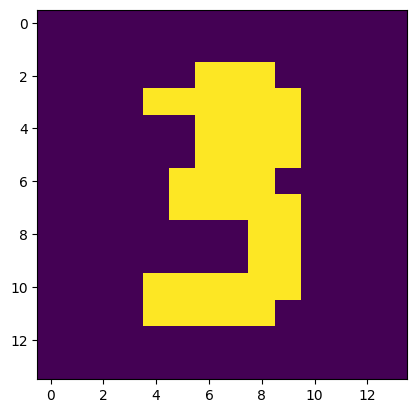

In [11]:
class_label = 3

output_layer_spins = np.ones(40).reshape(10, 4) * -1
output_layer_spins[class_label, :] = 1

print(normal_model.label_to_num(output_layer_spins.reshape(1, 40)))

plt.cla()
with torch.no_grad():
    result = np.array(normal_model.forward(torch.tensor(output_layer_spins.reshape(1, 40)).float()))
    result = result.flatten()

plt.imshow((result.reshape(14, 14) > 0)*2)